<h1> 2. Gráficos de series de tiempo. </h1> <br> Los gráficos permiten visualizar muchas características de los datos, incluidos patrones, observaciones inusuales, cambios a lo largo del tiempo y relaciones entre variables. Las características que se ven en los gráficos de los datos deben incorporarse, tanto como sea posible, en los métodos de pronóstico que se utilizarán. Así como el tipo de datos determina que método de pronóstico usar, también determina que gráficos son apropiados.  <br> <h2> 2.1 tsibble objetos </h2> <br> <br> Se puede pensar en una serie de tiempo como una lista de números (las medidas) junto con cierta información sobre las horas en que se registraron esos números (el índice).

In [13]:
library(fpp3)
library(readr)
library(ggplot2)
library(xts)
library(forecast)
library(dplyr)
library(tseries)
library(zoo)
library(quantmod)
library(TTR)

In [14]:
y <- tsibble(Año =2015:2019, Observacion =c(123,39,78,52,110), index = Año)
y

Año,Observacion
2015,123
2016,39
2017,78
2018,52
2019,110


Los objetos amplían los marcos de datos ordenados ( **tibble** objetos) mediante la introducción de una estructura temporal. Hemos configurado la serie temporal **index** para que sea **Año** columna, que asocia las medidas(**Observacion**) con el tiempo de registro (**Año**).

**Lea un archivo csv y conviértalo en un tsibble**  <br> <br> La mayoría de los datos viven en bases de datos, archivos Excel o archivos csv, antes de importales a R. Por lo tanto, a menudo, el primer paso para crear un *tsibble* es leer los datos y luego identificar el índice y las variables clave. Por ejemplo, supongamos que tenemos los siguieten datos trimestrales almacenados en un archivo csv (solo se muestran las primeras $10$ filas). Este conjunto de datos brinda información sobre el tamaño de la población carcelaria en Australia, desglosada por estado, género, estatus, legal y estatus indígena.

In [15]:
Prision <- readr::read_csv("https://OTexts.com/fpp3/extrafiles/prison_population.csv")
head(Prision, 5)

Parsed with column specification:
cols(
  Date = col_date(format = ""),
  State = col_character(),
  Gender = col_character(),
  Legal = col_character(),
  Indigenous = col_character(),
  Count = col_double()
)


Date,State,Gender,Legal,Indigenous,Count
2005-03-01,ACT,Female,Remanded,ATSI,0
2005-03-01,ACT,Female,Remanded,Non-ATSI,2
2005-03-01,ACT,Female,Sentenced,ATSI,0
2005-03-01,ACT,Female,Sentenced,Non-ATSI,5
2005-03-01,ACT,Male,Remanded,ATSI,7


Podemos leerlo en $R$ y crear un objeto **tsibble**, simplemente identificando que columna contiene el índice de tiempo y que columnas son claves. Las columnas restantes son valores; puede haber muchas columnas de valores, aunque en este caso so hay una (**Count**) . El archivo csv original almacenó las fechas como días individuales, aunque los datos son en realidad trimestraes, por lo que debemos convertir la **Date** variable a trimestres.

In [16]:
Prision <- Prision %>% mutate(Quarter = yearquarter(Date) ) %>% select(-Date) %>%
  as_tibble(key = c(State, Gender , Legal, Indigenous), index = Quarter)
head(Prision,5)

State,Gender,Legal,Indigenous,Count,Quarter
ACT,Female,Remanded,ATSI,0,2005 Q1
ACT,Female,Remanded,Non-ATSI,2,2005 Q1
ACT,Female,Sentenced,ATSI,0,2005 Q1
ACT,Female,Sentenced,Non-ATSI,5,2005 Q1
ACT,Male,Remanded,ATSI,7,2005 Q1


Este *tsibble* contiene $64$ series de tiempo separados correspondientes a las combinaciones de los $8$ estados, $2$ géneros, $2$ estados legales y $2$ estados índigneas. Cada una de estas series tiene una longitud de $48$ observaciones, desde el primer trimestre de $2005$ hasta el cuarto trimestre de $2016$.

**El período estacional:** Algunos gráficos y algunos modelos utilizarán el período estacional de los datos. El período estacional es el número de observaciones antes de que se repita el patrón estacional. En la mayoría de los casos, esto se detectará automáticamente utilizando la variable de índice de tiempo. Para los datos trimestrales, mensuales y semanales, solo hay un período estacional: el número de observaciones dentro de cada año. En realidad, no hay semanas en un año, sino en promedio, lo que permite un año bisiesto cada cuatro años.

<h2> 2.2 Patrones de series de tiempo </h2> <br> Al describir las series temporales, podremos encontrar palabras como "tendencia" y "estacionalidad", las cuales se definen de la siguiente manera: 

**Tendencia:** Una *tendencia* existe cuando hay un aumento o disminución a largo plazo en los datos. No tiene que ser lineal. A veces nos referiremos a una tendencia como "cambio de dirección", cuando podría pasar de una tendencia creciente a una tendencia decreciente.  <br>

**Estacional:** Un patrón *estacional*  ocurre cuando una serie de tiempo se ve afectada por factores estacionales como la época del año o el día de la semana. La estacionalidad es siempre de un período fijo y conocido. <br>

**Cíclico:** Un *ciclo* ocurre cuando los datos exhiben subidas y bajadas que no tienen una frecuencia fija. Estas fluctuaciones generalmente se deben a las conidiciones económicas y, a menudo, están relacionadas con el "ciclo económico".


Mucha gente confunde el comportamiento cíclico con el comportamiento estacional, pero en realidad son bastantes diferentes. Si las fluctuaciones no son de una frecuencia fija entonces son cíclicas; si la frecuencia no cambia y está asociada con algún aspecto del calendario, entonces el patrón es estacional. En general, la duración media de los ciclos es mayor que la duración de un patrón estacional. y las magnitudes de los ciclos tienden a ser más variables que las magnitudes de los patrones estacionales. Muchas series de tiempo incluyen tendencia, ciclos y estacionalidad. Al elegir un método de pronóstico, primero necesitaremos identificar los patrones de series de tiempo en los datos y luego elegir un método que pueda capturar los patrones correctamente.

<h2> 2.3 Parcelas estacionales </h2> <br> Una **gráfica estacional** es similar a una gráfica de tiempo, excepto que los datos se grafican contra las "estaciones" individuales en las que se observaron los datos. Analicemos la siguiente serie de tiempo. 

In [17]:
setwd("C:\\Users\\81799\\OneDrive\\Documentos\\ESFM_CLASES\\Servicio Social ARTF\\Machine Learning\\section1\\ARTF_2017_2020\\ABRIL_ARTF")
Ton_Netas_P <- read.csv("Toneladas_Netas__Productos_2014_2022.csv")
Ton_Netas_P <- Ton_Netas_P[-99,]
Ton_Netas_P$X <- as.yearmon(as.factor(Ton_Netas_P$X), format ="%m/%Y")
Ton_Netas_P <- xts(Ton_Netas_P[,c(2:6)], order.by = Ton_Netas_P$X )

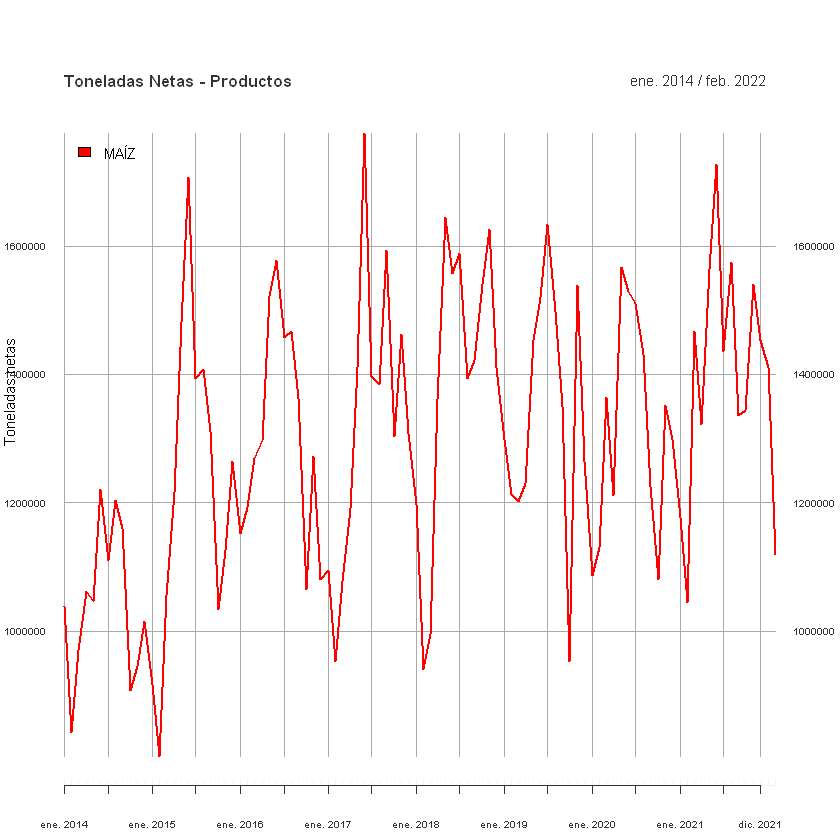

In [18]:
setwd("C:\\Users\\81799\\OneDrive\\Documentos\\ESFM_CLASES\\Servicio Social ARTF\\Machine Learning\\section1\\ARTF_2017_2020\\ABRIL_ARTF")
Ton_Netas_P <- read.csv("Toneladas_Netas__Productos_2014_2022.csv")
Ton_Netas_P <- Ton_Netas_P[-99,]
Ton_Netas_P$X <- as.yearmon(as.factor(Ton_Netas_P$X), format ="%m/%Y")
Ton_Netas_P <- xts(Ton_Netas_P[,c(2:6)], order.by = Ton_Netas_P$X )
T_N_P <-  data.frame(Ton_Netas_P) #Ordeno por fechas y la trae como indice
Maiz_ts <- ts(T_N_P[,1],  frequency = 12, star = c(2014,1))
color_T_N_P <- rainbow(ncol(Ton_Netas_P))
plot.xts(Ton_Netas_P[,1] , col = color_T_N_P ,
legend.loc = "topleft" , lwd = 2,
cex = 0.5, ylab = "Toneladas netas", xlab ="Tiempo",
cex.axis = 0.7,
main = "Toneladas Netas - Productos ")

Ahora haciendo su gráfica estacional, tenemos lo siguiente:

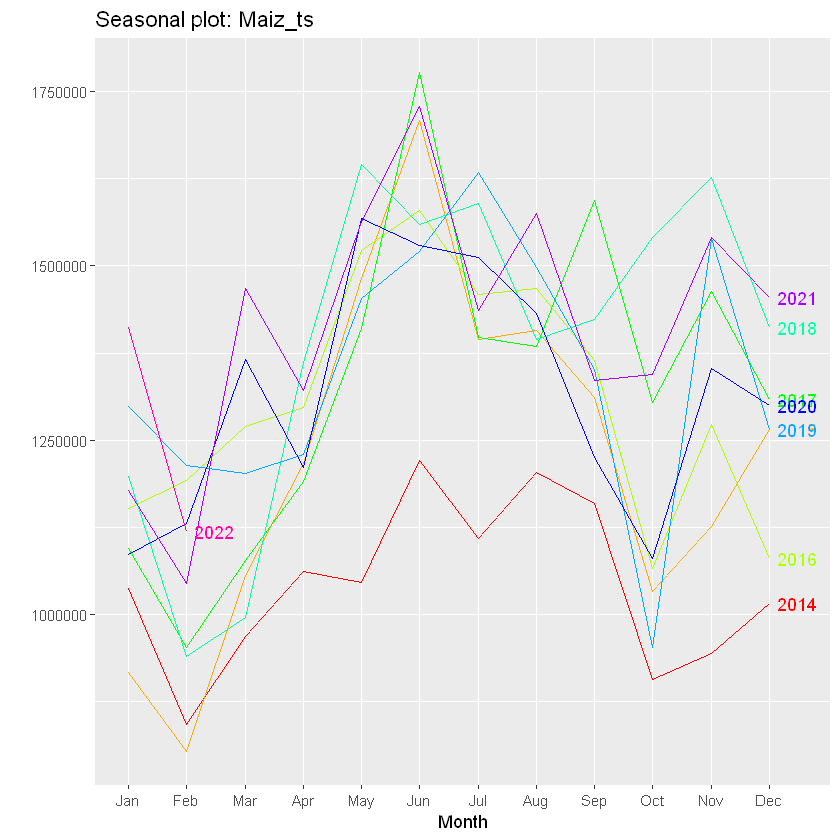

In [19]:
ggseasonplot(Maiz_ts,  year.labels =T, col = rainbow(9)) #Gráfica las parcelas estacionales.

Estos son los mismos datos que se mostraron anteriormente, pero los datos de cada temporada se superponen. Un **gráfico estacional** permite ver más claramenete el patrón estacional subyacente y es especialmente útil para identificar los años en los que cambia el patrón. 


<h2> 2.4 Gráfica de subseries estacionales </h2> <br> Una gráfica alternatuva que enfatiza los patrones estacionales es donde los datos de cada temporada se recopilan juntos en mini gráficas de tiempo serparadas. 

Una gráfica de subserie estacional faceta la serie temporal por cada estación en el período estacional. Esta faceta forman gráficos de series de tiempo más pequeños que consisten en datos solo de esa temporada. Si tuviera varios años de datos (mensuales, trimestrales, diarios, anuales, etc), el gráfico resultante mostraría un gráfico de serie de tiempo separado por cada período (ya sea mes, año, días) que se este trabajando la serie de tiempo.

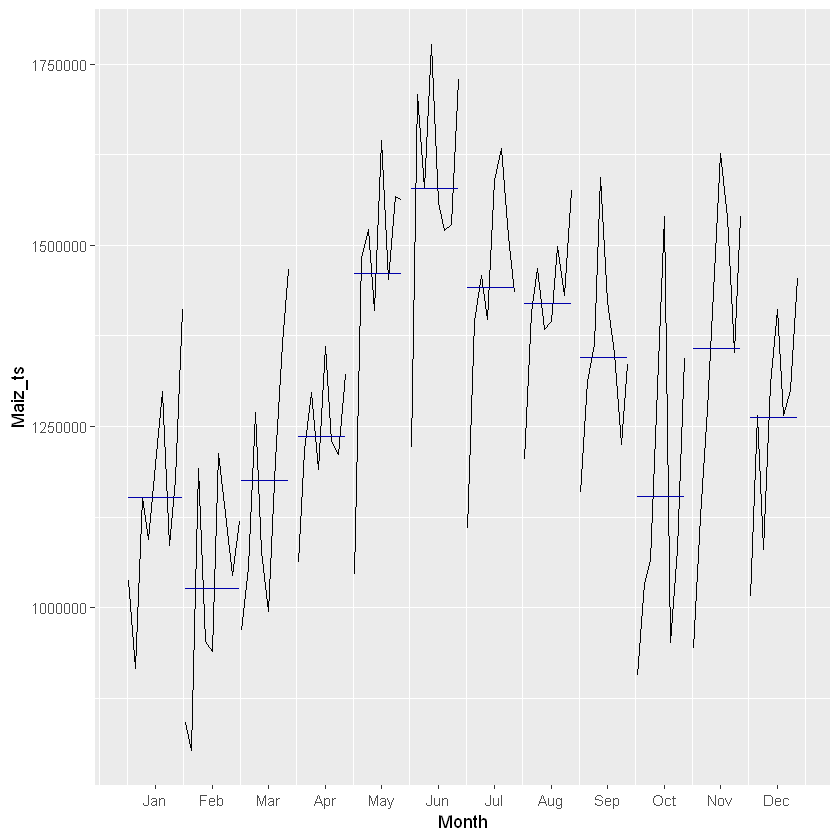

In [20]:
ggsubseriesplot(Maiz_ts)

Las lineas horizontales azules indican las meidas de cada mes. Esta forma de gráfico permite ver claramente el patrón estacional subyacente y también muestra los cambios en la estacionalidad a lo largo del tiempo. Es especialmente útil para identificar cambios dentro de estaciones particulares.
Notemos que la serie de tiempo esta dada en forma mensual, es por eso que hace un gráfico estacional separado por mes.

<h2> 2.5 Gráficas de retraso </h2>

Un gráfico de retraso es un tipo especial de gráfico de dispersión en el que el eje $x$ representa el conjunto de datos con algunas unidades de tiempo atrás o adelante en comparación con el eje $y$. La diferencia entre estas unidades de tiempo se llama retraso y se representa por $k$

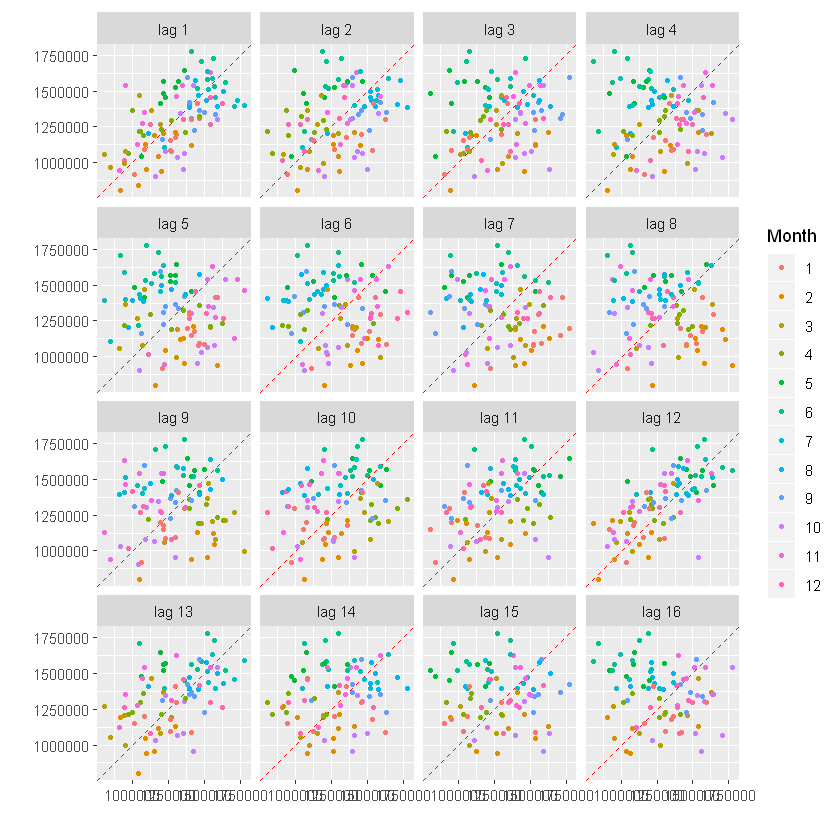

In [21]:
gglagplot(Maiz_ts, do.lines =FALSE , diag = TRUE , diag.col = "red")

La relación es fuertemente positiva en el rezago $1$ y $12$ (  $\varphi _1$ y $\varphi _{12}$ ) lo que refleja la fuerte estacionalidad de los datos.

<h2> 2.6 Autocorrelación </h2> 

Así como la **correlación** mide el alcance de una relación lineal entre dos variables, la **autocorrelación** mide la relación lineal entre los *valores rezagados* de una serie de tiempo. Hay varios coeficiente de autocorrelación, correspondientes a cada panel en el gráfico de retardo, es decir, $\varphi _k(t)=corr(y_t,y_{t-k})$ Por ejemplo, $\varphi _1(t)$ mide la relación entre $y_1$ y $y_{t-1}$, $\varphi _2(t)$ mide la relación entre $y_t$ y $y_{t-2}$, y así sucesivamente. El valor de $\varphi _k(t)$ se úede escribir como  $$ \varphi _k =\frac{\sum \limits _{t=k+1}^T (y_t-\bar{y})(y_{t-k}-\bar{y}) }{\sum \limits _{t=1}^T (y_t-\bar{y})^2} $$ donde $T$ es la duración de la serie temporal. Los coeficientes de autocorrelación componen la *función de autocorrelación* o **ACF**

Los valores de autocorrelación y la gráfica están dados de la siguiente manera


Autocorrelations of series 'ts(Maiz_ts)', by lag

     0      1      2      3      4      5      6      7      8      9     10 
 1.000  0.608  0.359  0.157 -0.032 -0.088 -0.058 -0.115 -0.079  0.039  0.210 
    11     12     13     14     15     16     17     18     19     20     21 
 0.342  0.547  0.360  0.124 -0.055 -0.135 -0.191 -0.141 -0.184 -0.149 -0.065 
    22     23     24     25     26     27     28     29     30     31     32 
 0.075  0.214  0.353  0.236  0.127 -0.026 -0.101 -0.073 -0.068 -0.126 -0.086 
    33     34     35     36 
-0.039  0.097  0.239  0.314 

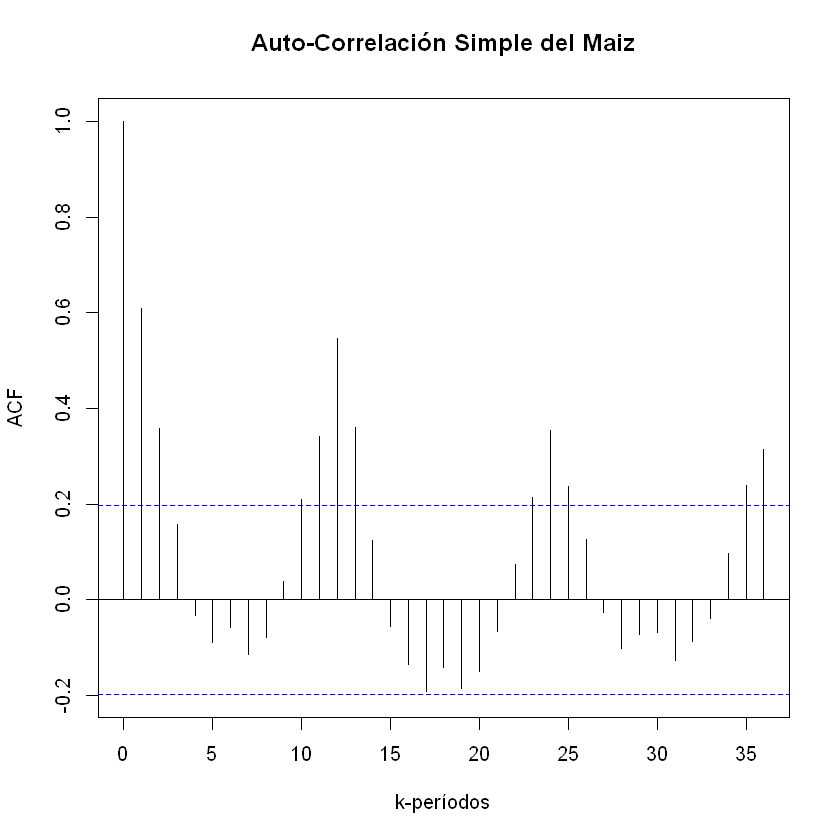

In [22]:
(acf(ts(Maiz_ts), lag.max=36, 
     main = "Auto-Correlación Simple del Maiz",
xlab ="k-períodos"))

Dado los valores y la gráfica de auto-correlación simple, tenemos que $\varphi _1 =0.608$ y $\varphi _{12}=0.547$, es decir , es conveniente predecir el futuro ya sea con $1$ o $12$ retrasos (Entre más cercano a 1 es mejor). Lo anterior lo podremos expresar de la siguiente manera:

$\varphi _1(t)=corr(X_t,X_{t-1})=0.608$ 

$\varphi _{12}(t)= corr(X_t,X_{t-12})=0.547$

**Tendencia y estacionalidad en parcelas ACF**

Cuando los datos tienen una tendencia, las autocorrelaciones para pequeños retrasos tienden a ser grandes y positivas porque las observaciones cercanas en el tiempo también tienen un valor cercano. Entonces, el *ACF* de una serie de tiempo con tendencia tiende a tener valores positivos que disminuyen lentamente a medida que aumentan los retrasos.

Cuando los datos son estacionales, las autocorrleaciones serán mayores para los retrasos estacionales (en múltiplos de período estacional) que para otros retrasos. Cuando los datos son de tendencia y estacionales, se ve una combinación de estos efectos.

<h2> 2.10 Ruido Blanco </h2>

Las series de tiempo que no muestran autocorrelación se denominan **ruido blanco**. Para las series de ruido blanco, esperamos que cada autocorrelación sea cercana a $0$. Por supuesto, no serán exactamente iguales a $0$ ya que existe alguna variación aleatoria. Para una serie de ruido blanco, esperamos que el $95$% de los picos en el ACF se encuentren dentro de donde es la longitud de la serie temporal. Es común trazar estos límites en un gráfico del *ACF* (las líneas discontinuas azules de arriba). Si uno o más picos grandes están fuera de estos limites, o si sustancialmente más del $5$% de los picos están fuera de estos limites, es probable que la serie no sea ruido blanco.